# ARIMA Models Tutorial

*Authors: Garyaeva Elvina, Pei Yunying, Sobakinskikh Ilya.*

In this tutorial, we will explore the implementation of ARIMA model using python on a data set about global land temperatures. Auto Regressive Integrated Moving Average model is a class of models that uses its own lags(AR model) and the lagged forecast errors(MA modek) to forecast future values. The 'I' in ARIMA determines the level of differencing to use, which helps to make the time series stationary. It is a widely applicable model that is known for its flexibility.

The tutorial consists of following parts:

---
### Table of Contents

1. Data preprocessing

2. Model selection and evaluation

  - Evaluation of naive model

  - Selection and evaluation of specific ARIMA model

  - Automatic selection of the best ARIMA model

3. Comparison of models with sliding window

4. Conclusion 



---




For better user experience and environment stability (pip), you can access the notebook on [google colab](https://colab.research.google.com/drive/1e_ncRfhz5JF_AqEloUUfNKyqzUEYiU8B?usp=sharing)

Note in advance: throughout this tutorial, the performance of all models are measured by the smape loss([Symmetric mean absolute percentage error](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error)) :


$$smape = \frac{1}{H} \sum_{i = T+1}^{T+H} \frac{|y_i - \hat y_i|}{(|y_i| + |\hat y_i|)/2}$$

If you are using google colab you need to install the following packages

In [ ]:
!pip install -q sktime 
!pip install -q pmdarima

     |████████████████████████████████| 5.7MB 5.4MB/s 
     |████████████████████████████████| 9.5MB 50.4MB/s 
     |████████████████████████████████| 22.3MB 1.8MB/s 
     |████████████████████████████████| 1.5MB 5.8MB/s 
     |████████████████████████████████| 2.1MB 25.9MB/s 


## I. Data preprocessing

We start with importing necessary libraries. The most practical and popular library used for fitting ARIMA models is sktime, and we will also apply it here.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.set_style("whitegrid", {'axes.grid' : False})

from tqdm.auto import tqdm

In [ ]:
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.model_selection import temporal_train_test_split, SlidingWindowSplitter, ForecastingGridSearchCV
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import smape_loss

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sktime.forecasting.naive import NaiveForecaster

The data set being used, *GlobalLandTemperatures*, is downloaded from [data.world](https://data.world/), contains the records of global land temperatures from 1750 to 2015.
The variable 'LandAverageTemperature', i.e. the average temperature of the land (°C) recorded each month, was chosen as response variable.
Evidently, the series has seasonal component that can be attributed to meteorological seasonality.


First, we preprocess the data by removing nan values. In this tutorial, only the 200 latest statistics will be used (i.e. time frame from 1999-05 to 2015-12). We also have to convert the time values from type "base" to type "period" in order to work with sktime functions.

In [ ]:
# the dataset was uploaded to pastebin.com
# DATA_URL = 'https://pastebin.com/raw/byX6Hsb8'
# u can use it if you don't have access to the csv

data = pd.read_csv('weather.csv')[['LandAverageTemperature', 'dt']]
data.dropna(inplace=True)

data.set_index("dt", inplace=True)
data.index = pd.to_datetime(data.index)

data = data.tail(200)

# needed for seasonal_decompose
# probably a bug in the implementation
y_no_period = data['LandAverageTemperature'] 
data.index = data.index.to_period("M")

Define y as the 'LandAverageTemperature' variable:

In [ ]:
y = data['LandAverageTemperature']
y

dt
1999-05    11.706
1999-06    14.031
1999-07    14.853
1999-08    14.348
1999-09    12.723
            ...  
2015-08    14.755
2015-09    12.999
2015-10    10.801
2015-11     7.433
2015-12     5.518
Freq: M, Name: LandAverageTemperature, Length: 200, dtype: float64

Let's now plot the time series to get a better interpretation of it:

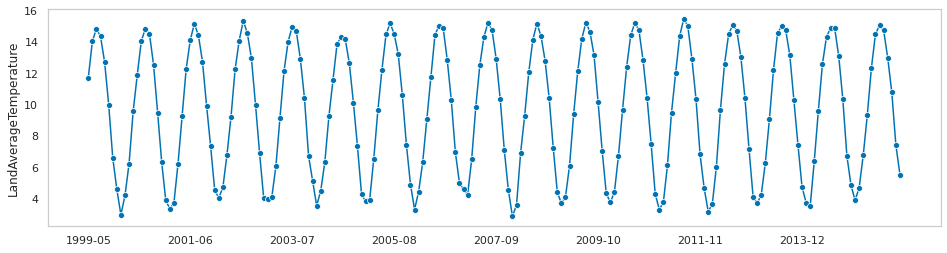

In [ ]:
plot_series(y);

Generally, a time series is comprised of four main components:
1. Level - the average value in the series.
2. Trend - the increasing or decreasing value in the series.
3. Seasonality - reoccuring pattern at a fixed and known frequency based on a specific period of time.
4. Random noise.

To help up gain a clearer vision of the data, we can use seasonal_decompose from statsmodels to quickly plot the series decomposed into trend, seasonal and residual parts:

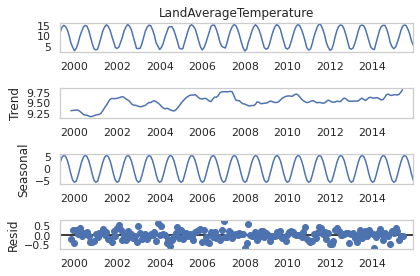

In [ ]:
# Perform additive decomposition
decomp = seasonal_decompose(y_no_period, period=12)

# Plot decomposition
decomp.plot()
plt.show()

We can see that the temperature is clearly seasonal and the trend, although with some fluctuations, is generally positive.

## II. Model selection and evaluation

Now that the data has been preprocessed and we've had a quick glance at it, we can move on to fitting and evaluating models. In order to appropriately fit a model, it has to be trained on the training data set first, and then its performance will be evaluated with test set. We've defined the test set to be the last 36 observations in y (i.e. 3 years), and train to be the first, because in time series our goal is to predict future outcomes with the knowledge of information in the past.

In [ ]:
y_train, y_test = temporal_train_test_split(y, test_size=36)

Let's visualize the training and test observations:

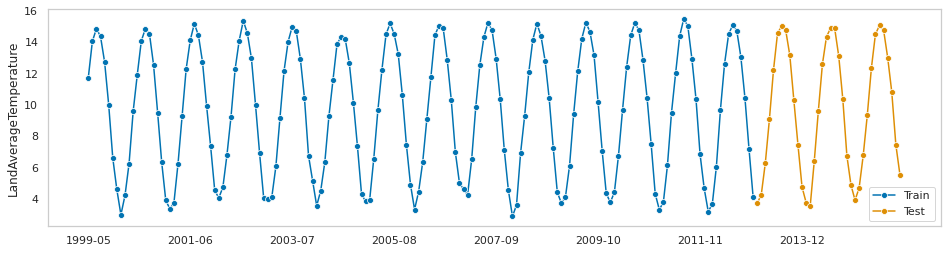

In [ ]:
plot_series(y_train, y_test, labels=['Train', 'Test']);

Now we have everything needed to fit the model! One last step: in sktime, the model does not make predictions based on the indexes(time values) of *y_test*. Rather, they are required to be first converted into the so-called *horizon*. This can be easily done with *ForecastingHorizon* function:

In [ ]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh_train = ForecastingHorizon(y_train.index, is_relative=False)

### Evaluation of naive seasonal model


Let's start with fitting the simplest model - the naive model. Naive model is an estimating technique in which the last period's values are used as this period's forecast, without any adjustments. Naive model is generally used for comparisons with more sophisticated models. 

Because there exists observable seasonality in the data, it makes more sense to apply naive seasonal model, in which the last seasonal period's actual will be repeatedly applied to forecasting periods. 

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f80961dbc10>)

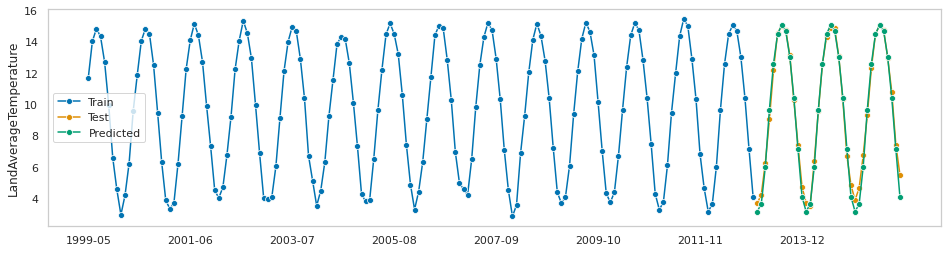

In [ ]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["Train", "Test", "Predicted"])

The smape loss of Naive model is 0.0614.

In [ ]:
print("Smape loss of naive model: ", smape_loss(y_pred, y_test))

Smape loss of naive model:  0.06143329950936208


### Evaluation of a specific ARIMA model

Next, we move on to the full fitting process on a selected ARIMA model. Basically, in order to choose a more suitable model, we have to decide on which parameters to use. By purely looking at the graph, it can be seen that clear seasonality exists, so we can assume that seasonal ARIMA should be applied. The parameters in a seasonal ARIMA, $ARIMA(p,d,q)(P,D,Q,m)$ are as follows:

$p$ - number of estimated coefficients in non-seasonal AR part

$d$ - number of transitions to non-seasonal difference

$q$ - number of estimated coefficients in non-seasonal MA part

$P$ - number of estimated coefficients in seasonal AR 

$D$ - number of transitions to seasonal difference

$Q$ - number of estimated coefficients in seasonal MA part

$m$ - seasonality period


In this section, we will apply the widely used Box-Jenkins method - a systematic method of identifying, fitting, checking, and using ARIMA time series models to select the best model.

Firstly, most traditional time series models require the data to be stationary. If the data is not stationary, it would have to be transformed to remove trend and/or seasonality in order to proceed forecasting. 

Let's first examine the stationarity of data set with Dickey-Fuller's test.
The test tests whether our weather time series is stationary or not.

Formally, 

$H_0$: the series is non-stationary 


$H_a$: the series is stationary

Since the series has trend (see seasonal_decompose plot) we include trend component into the test (see [the 3rd version of the test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test#Explanation))

In [ ]:
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(y, regression='ct')
pvalue

0.010702168122354583

We can see that the p-value is slightly above 1% => the data is *almost* stationary.

The test, however, does not assume that the data might be seasonal.

In the next cell we will check if taking seasonal difference with a period of 12 would make a difference.

In [ ]:
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(y.diff(12).dropna(), regression='ct')
pvalue

0.005301829784412176

The obtained p-value is less than 1% => the data is stationary and there is no need to take non-seasonal difference if seasonal difference (period=12) is present.

Next, we determine the parameters of the stationary ARIMA model using ACF(auto-correlation function) and PACF(partial auto-correlation function) plots with the following decision rule:

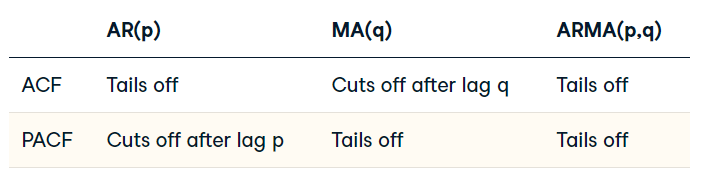

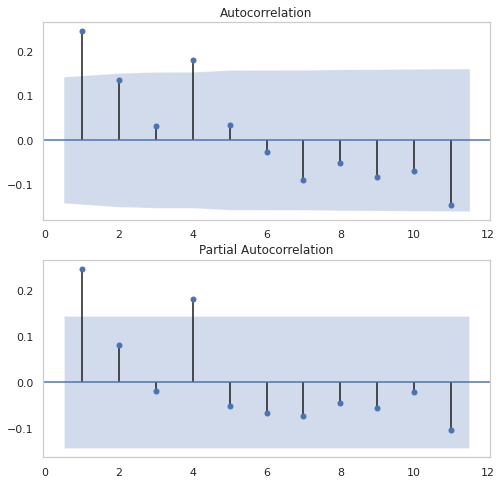

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,8))

# Plot the ACF on ax1
y_diff = y.diff(12).dropna()
plot_acf(y_diff,lags=11,zero=False,ax=ax1)

# Plot the PACF on ax2
plot_pacf(y_diff,lags=11,zero=False,ax=ax2)

plt.show()

Both the non-seasonal ACF and PACF tail off, and it is not possible to deduce which parameters are optimal to choose from the plots. What about the seasonal part?

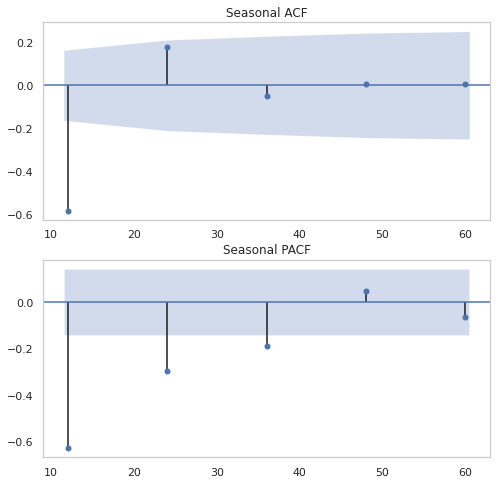

In [ ]:
lags = [12, 24, 36, 48, 60]

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,8))

# Plot the ACF on ax1
plot_acf(y_diff,lags=lags,zero=False,ax=ax1,title="Seasonal ACF")

# Plot the PACF on ax2
plot_pacf(y_diff,lags=lags,zero=False,ax=ax2,title="Seasonal PACF")

plt.show()

The seasonal ACF cuts off after lag 1, thus the seasonal parameters can be chosen as: $P = 0, D=1, Q=1$ and $m=12$.

We still have to decide on non-seasonal parameters. To make a good guess, we will fit a few ARIMA models by iterating through several values of p and q:

In [ ]:
order_smape = []

for p in tqdm(range(4)):
  for q in range(4):
    forecaster = ARIMA(
        order=(p, 0, q), seasonal_order=(0, 1, 1, 12), suppress_warnings=True)
    fc_fit = forecaster.fit(y_train)

    y_pred = forecaster.predict(fh_train)
    smape_train = smape_loss(y_train, y_pred)

    y_pred = forecaster.predict(fh)
    smape_test = smape_loss(y_test, y_pred)
    order_smape.append((p,q,smape_train, smape_test))

In [ ]:
order_df = pd.DataFrame(order_smape, columns=['p','q','smape train', 'smape test'])
order_df = order_df.sort_values('smape train')
order_df.head()

,p,q,smape train,smape test
14,3,2,0.180137,0.032413
13,3,1,0.180329,0.032495
10,2,2,0.180337,0.032440
9,2,1,0.180340,0.032098
11,2,3,0.180372,0.032597


p and q equal to 3 and 2 respectively give the best error value on the validation set

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8096539150>)

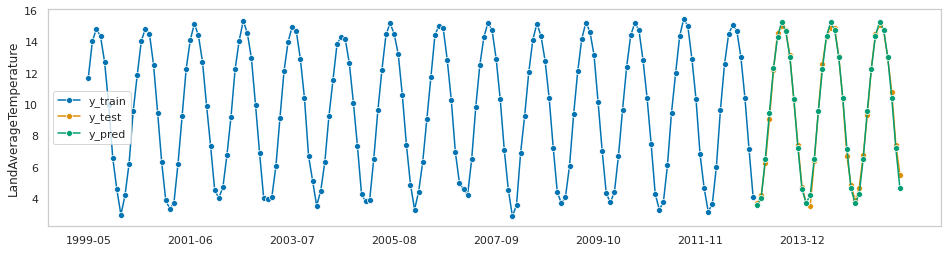

In [ ]:
forecaster = ARIMA(
        order=(3, 0, 2), seasonal_order=(0, 1, 1, 12), suppress_warnings=True)
fc_fit = forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

The smape loss of ARIMA model selected with Box-Jenkins method is 0.0324.

In [ ]:
smape_loss(y_test, y_pred)

0.032413091041761294

Note that this is less that the error of the naive forecaster (0.0614)

We can obtain more information with the summary function:

In [ ]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  164
Model:             SARIMAX(3, 0, 2)x(0, 1, [1], 12)   Log Likelihood                 -32.717
Date:                              Mon, 01 Mar 2021   AIC                             81.433
Time:                                      12:44:29   BIC                            105.624
Sample:                                           0   HQIC                            91.261
                                              - 164                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0395      0.020      1.962      0.050    3.14e-05       0.079
ar.L1         -1.4291      0.126    -11.376      0.000      -1.675      -1.183
ar.L2         -0.0549      0.155     -0.355      0.723      -0.358       0.248
ar.L3          0.4022      0.066      6.124      0.000       0.273       0.531
ma.L1          1.7439      0.133     13.128      0.000       1.484       2.004
ma.L2          0.7619      0.136      5.601      0.000       0.495       1.028
ma.S.L12      -0.9525      0.275     -3.463      0.001      -1.492      -0.413
sigma2         0.0757      0.020      3.792      0.000       0.037       0.115
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.70
Prob(Q):                              0.97   Prob(JB):                         0.43
Heteroskedasticity (H):               0.76   Skew:                             0.05
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The summary table tells us that the model is of form

$$
(1-(-1.4291)L)(1-(-0.0549)L^2)(1-0.4022L^3)(1-L^{12})y_t
=0.0192+(1+1.7439L)(1+0.7619L^2)(1-0.9456L^{12})u_t
$$

### Automatic selection of the best ARIMA model

In this section, we implement the built-in *AutoARIMA* function, which automatically selects the best ARIMA model based on AIC criterion(by default). In *AutoARIMA* there is a wide variety of parameters to tune. For simplicity, we only specified *sp*, the period for seasonal differencing, to 12, which is the period by which the pattern in our data repeats. We fitted the model and plotted the prediction graph:

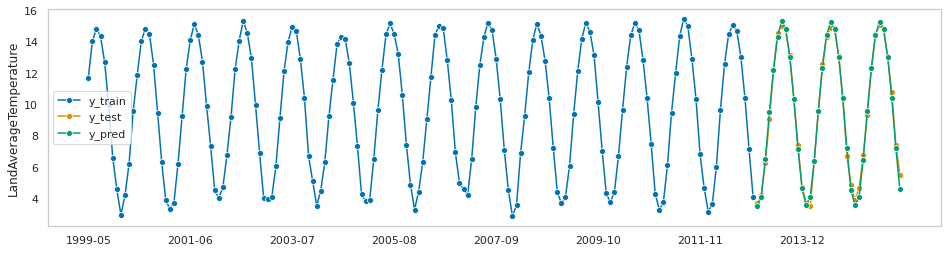

In [ ]:
auto_forecaster = AutoARIMA(sp=12, suppress_warnings=True)
auto_forecaster.fit(y_train)
y_pred = auto_forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

The graph depicts an almost flawless prediction! Let's derive the smape loss of automatically selected model:

The smape loss of automatic model is 0.03496.

In [ ]:
smape_loss(y_test, y_pred)

0.03496191897717126

Surprisingly, the loss is slightly greater for the automatically derived model.

We can again obtain more information with the summary function:

In [ ]:
auto_forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  164
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 12)   Log Likelihood                 -29.132
Date:                            Mon, 01 Mar 2021   AIC                             72.263
Time:                                    12:51:41   BIC                             93.431
Sample:                                         0   HQIC                            80.862
                                            - 164                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0226      0.014      1.663      0.096      -0.004       0.049
ar.L1         -0.3787      0.157     -2.410      0.016      -0.687      -0.071
ar.L2          0.4289      0.068      6.274      0.000       0.295       0.563
ma.L1          0.7028      0.170      4.132      0.000       0.369       1.036
ar.S.L12      -0.2984      0.100     -2.981      0.003      -0.495      -0.102
ma.S.L12      -0.7885      0.125     -6.313      0.000      -1.033      -0.544
sigma2         0.0763      0.008      9.014      0.000       0.060       0.093
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.92   Prob(JB):                         0.40
Heteroskedasticity (H):               0.69   Skew:                             0.22
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The summary table tells us that the model is of form

$$
(1-(-0.3787)L-0.4289L^2)(1-(-0.2984)L^{12})(1-L^{12})y_t
=0.0226+(1+0.7028L)(1+(-0.7885)L^{12})u_t
$$

Also, we can conclude that although the smape_loss of AutoARIMA model is greater than the manually specified ARIMA model, its AIC value is smaller than the latter, which is reasonable since we chose to optimize by AIC criterion.

And the 95% confidence interval:

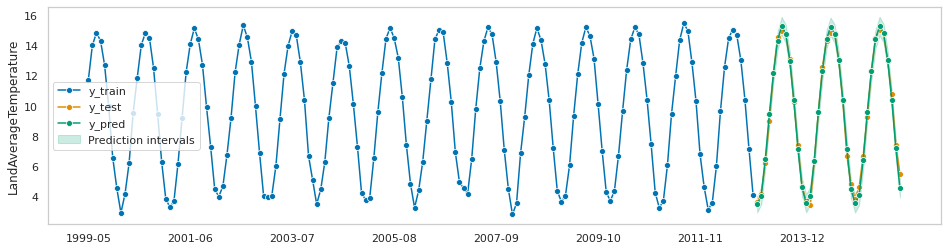

In [ ]:
alpha=0.05
y_pred, pred_ints = auto_forecaster.predict(fh, return_pred_int=True, alpha=alpha)

fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

plt.fill_between(
    range(len(y) - len(y_test), len(y)),
    pred_ints['lower'],
    pred_ints['upper'],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label='Prediction intervals',
)


plt.legend();

## III. Comparison of models

In this section, we will present an alternative approach to choose best ARIMA model, namely using a sliding window technique to compare the models. The technique is similiar to cross-validation technique used to select the best model in ML.

In particular, we will demonstrate on the non-seasonal part and choose p and q such that smape is minimal. For simplicity, the seasonal part derived from ACF-PACF analysis will be used.

Basically, we take continuous folds of data to train and to evaluate the model.
In the following example, the window length is 5, forecasting horizon is 3 and the step is 1, so the following folds are obtained:
```
|-----------------------|
| * * * * * x x x - - - |
| - * * * * * x x x - - |
| - - * * * * * x x x - |
| - - - * * * * * x x x |

* = training fold.
x = test fold.
```

In [ ]:
order_list = []

for p in range(0, 4):
  for q in range(0, 4):
    order_list.append((p, 0, q))

In [ ]:
order_smape = []

forecaster = ARIMA(suppress_warnings=True)
        
cv = SlidingWindowSplitter(
    window_length=37,
    fh=12, 
    initial_window=int(len(y_train) * 0.5)
)

In [ ]:
param_grid = {'order': order_list, 'seasonal_order': [(0, 1, 1, 12)]}
gscv = ForecastingGridSearchCV(forecaster, cv, param_grid, n_jobs=-1)

In [ ]:
fc_fit = gscv.fit(y_train)
y_pred = gscv.predict(fh)
smape_test = smape_loss(y_test, y_pred)
# order_smape.append((p, q, smape_test))

The smape value of ARIMA model selected with sliding window is 0.0324.

In [ ]:
smape_test

0.032417892133597165

In [ ]:
fc_fit.best_params_

{'order': (3, 0, 3), 'seasonal_order': (0, 1, 1, 12)}

Based on this the best p and q are 3 and 3 for the arima model with seasonal components.

## IV Conclusion

To summarize, in this tutorial we have seen the performance of various ARIMA models and different approaches to selecting them. The smape scores of the four models are listed below:

- The naive seasonal model: 0.0614
- The model by Box-Jenkins method: 0.0324
- AutoARIMA: 0.035
- The model by sliding window method: 0.0324

From the above we can conclude that the hand-selected models perform the best, and although their smape scores are the same, they do not actually coincide. Meantime, the naive seasonal model performs the worst, with the error score almost twice greater than the best models, which is no suprise since it is too 'naive'. 


Hope you have enjoyed this tutorial :)

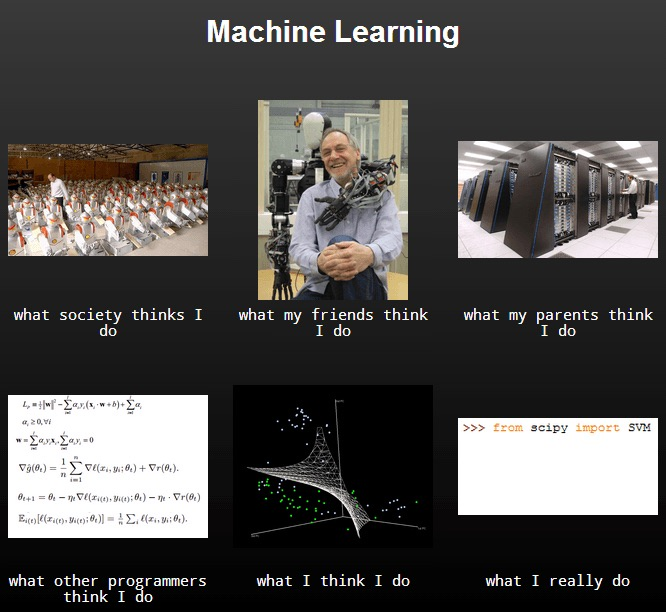